In [1]:
print(f"ipython: {str(get_ipython())}")
from IPython.display import clear_output
import numpy as np
import torch
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = '/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/'
else:
    print("Running in personal pc")
    root_path = 'Complementary_Files/zamuro_audios.csv'

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f108e652440>
Running on MIRP


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.2), len(dataset) - round(len(dataset)*0.2)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Zamuro",
    "audio_length": dataset.audio_length,
    "batch_size" : 20,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Zamuro",
    "architecture": "AE_Log",
    "win_length" : dataset.win_length,
    "step_size": 4,
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = config["step_size"], gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


cuda


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1 of 651 	 loss: 0.2726
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2 of 651 	 loss: 0.2932
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3 of 651 	 loss: 0.4938
error
Trying to create tensor with negative dimension -154028: [1, -154028]
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 5 of 651 	 loss: 0.2595
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 6 of 651 	 loss: 0.2677
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 7 of 651 	 loss: 0.259
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.S

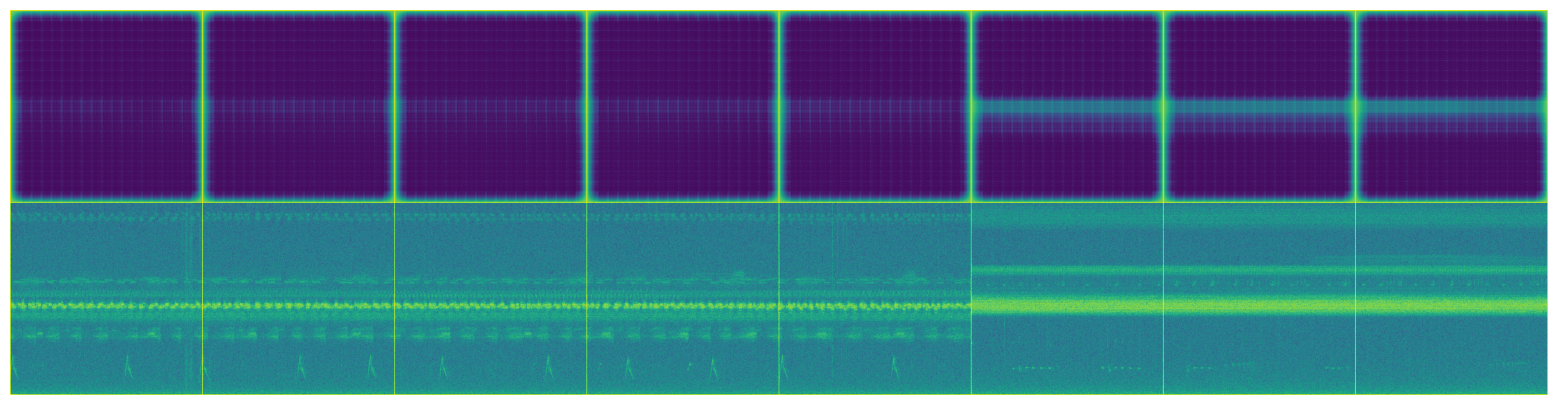

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 51 of 651 	 loss: 0.1389
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 52 of 651 	 loss: 0.028
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 53 of 651 	 loss: 0.0156
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 54 of 651 	 loss: 0.0501
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 55 of 651 	 loss: 0.0147
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 56 of 651 	 loss: 0.2615
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 57 of 651 	 loss: 

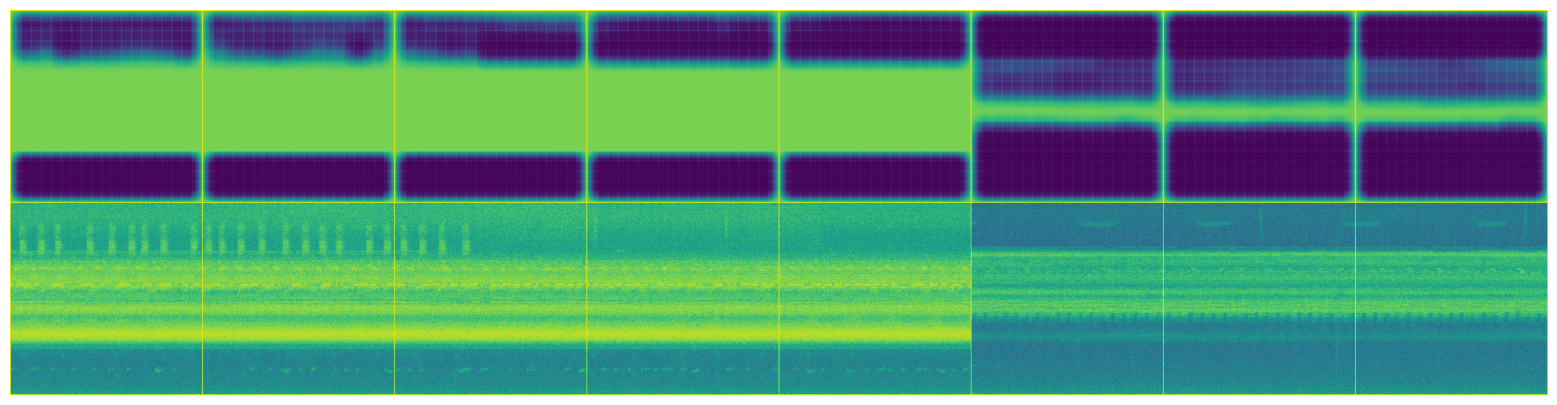

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 101 of 651 	 loss: 0.0143
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 102 of 651 	 loss: 0.0457
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 103 of 651 	 loss: 0.0274
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 104 of 651 	 loss: 0.0328
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 105 of 651 	 loss: 0.0238
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 106 of 651 	 loss: 0.0403
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 107 of 651 

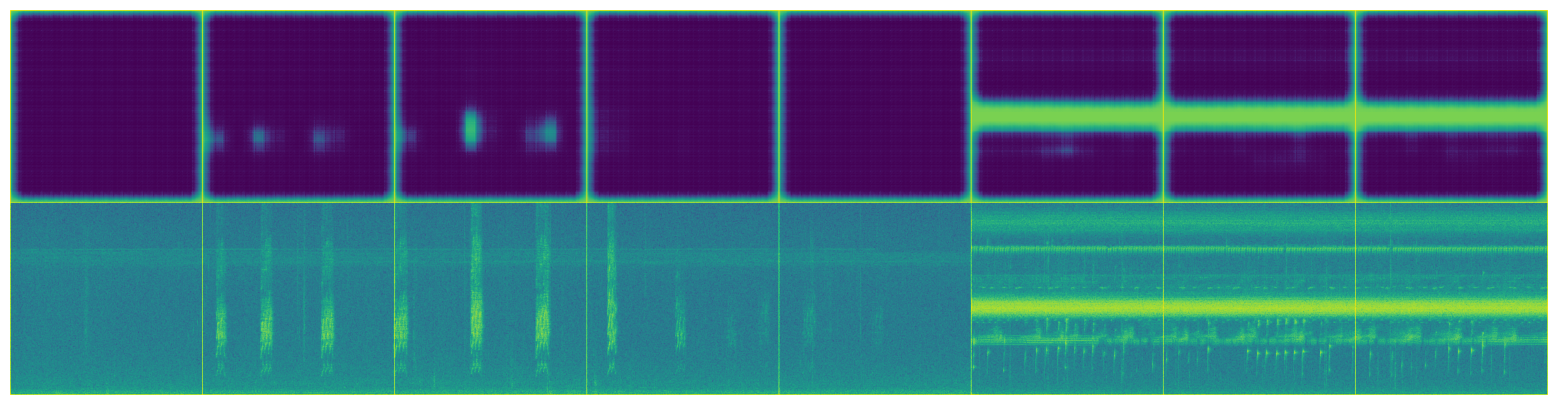

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 151 of 651 	 loss: 0.0179
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 152 of 651 	 loss: 0.0243
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 153 of 651 	 loss: 0.0615
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 154 of 651 	 loss: 0.0121
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 155 of 651 	 loss: 0.0231
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 156 of 651 	 loss: 0.0208
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 157 of 651 

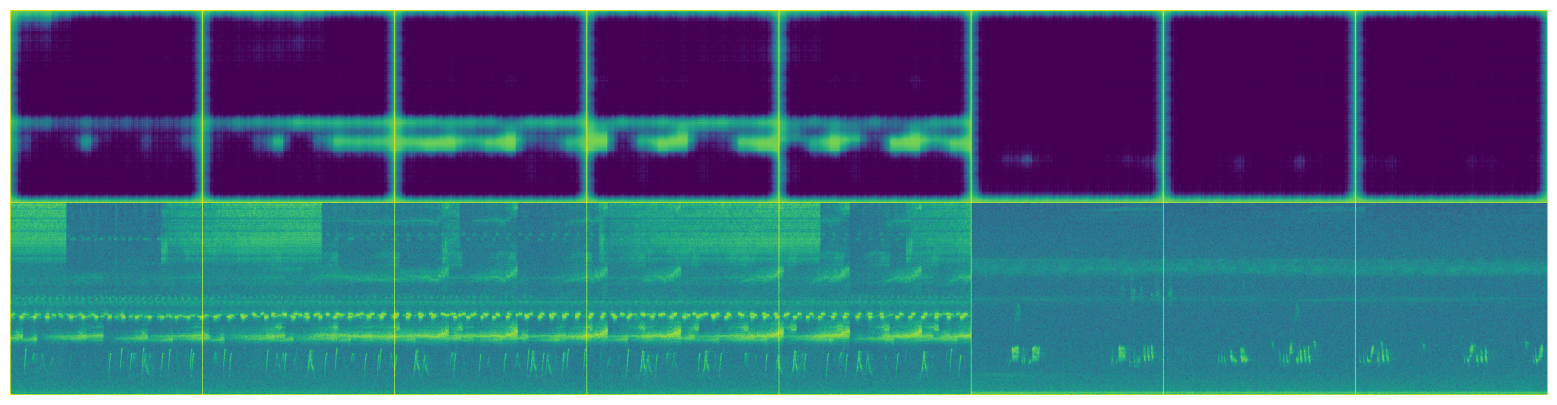

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 201 of 651 	 loss: 0.0954
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 202 of 651 	 loss: 0.008
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 203 of 651 	 loss: 0.0351
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 204 of 651 	 loss: 0.0136
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 205 of 651 	 loss: 0.017
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 206 of 651 	 loss: 0.0771
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 207 of 651 	 

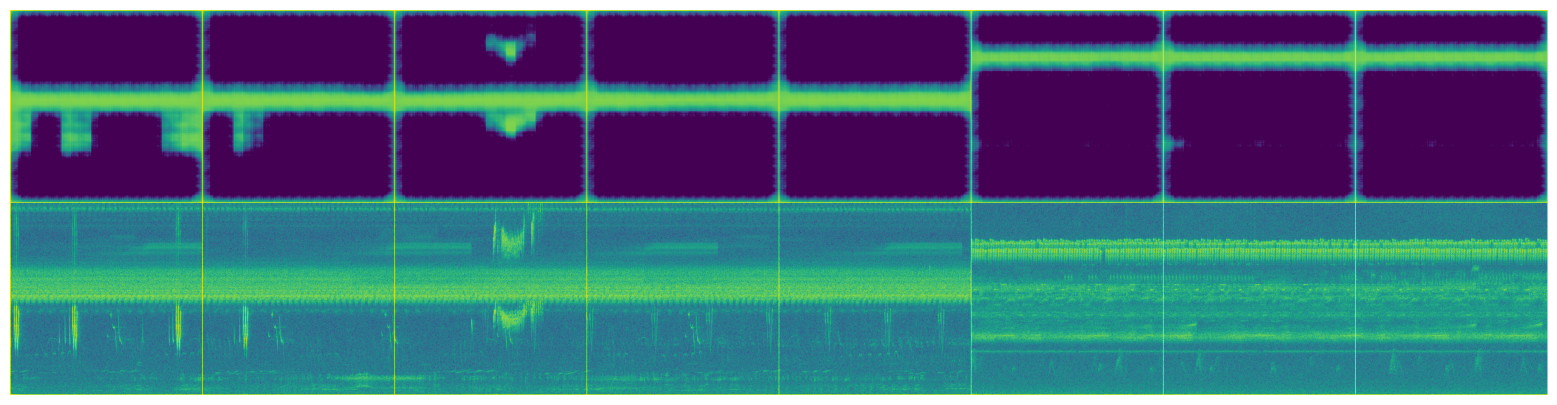

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 251 of 651 	 loss: 0.0304
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 252 of 651 	 loss: 0.0243
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 253 of 651 	 loss: 0.0277
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 254 of 651 	 loss: 0.0175
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 255 of 651 	 loss: 0.0127
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 256 of 651 	 loss: 0.015
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 257 of 651 	

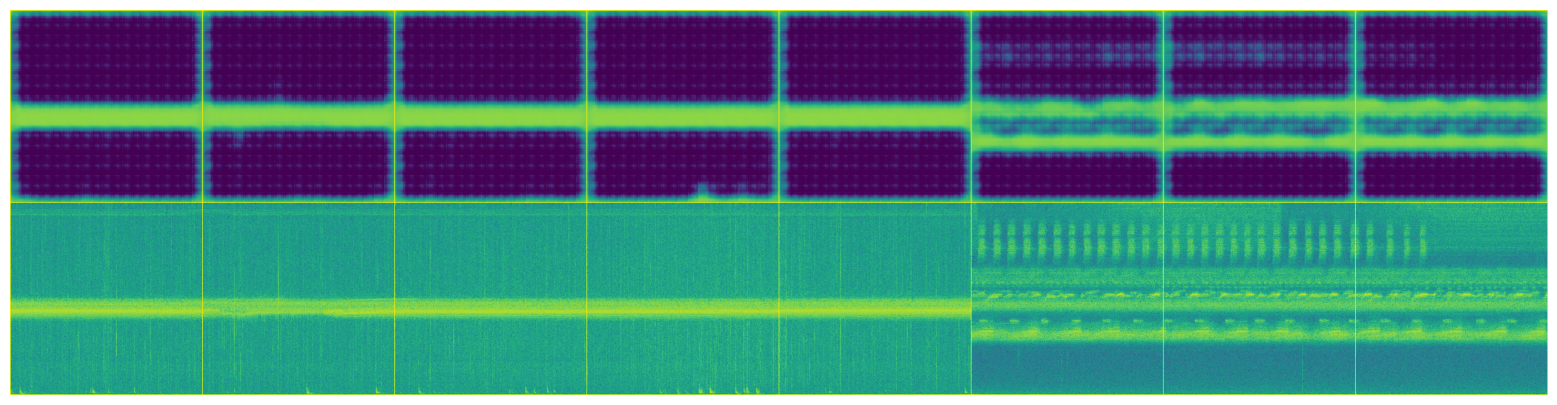

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 301 of 651 	 loss: 0.0113
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 302 of 651 	 loss: 0.0204
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 303 of 651 	 loss: 0.0132
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 304 of 651 	 loss: 0.0276
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 305 of 651 	 loss: 0.0157
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 306 of 651 	 loss: 0.0549
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 307 of 651 

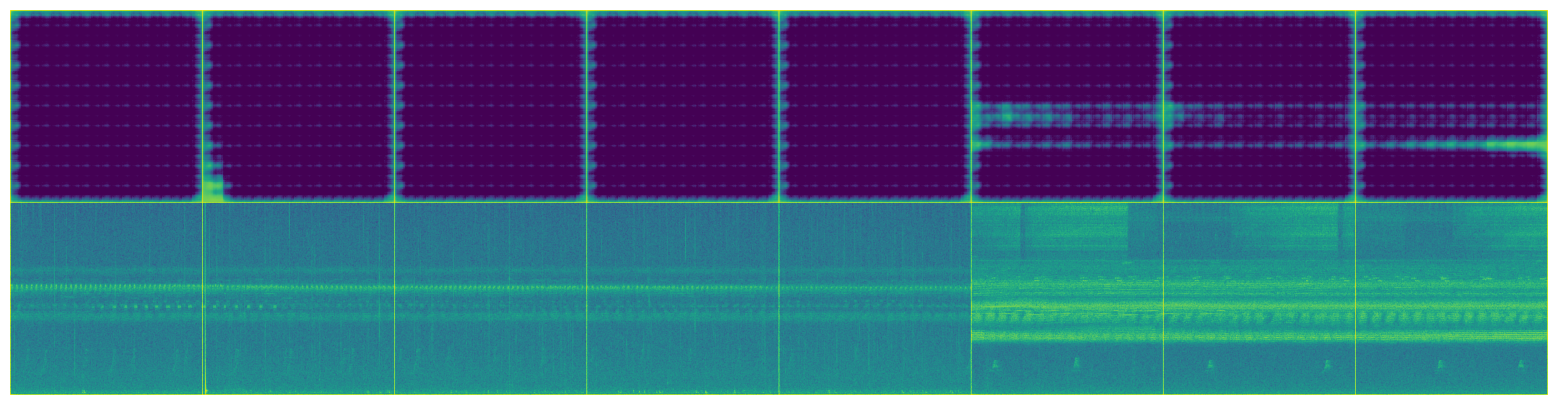

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 351 of 651 	 loss: 0.0109
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 352 of 651 	 loss: 0.0155
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 353 of 651 	 loss: 0.0083
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 354 of 651 	 loss: 0.0258
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 355 of 651 	 loss: 0.0758
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 356 of 651 	 loss: 0.0378
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 357 of 651 

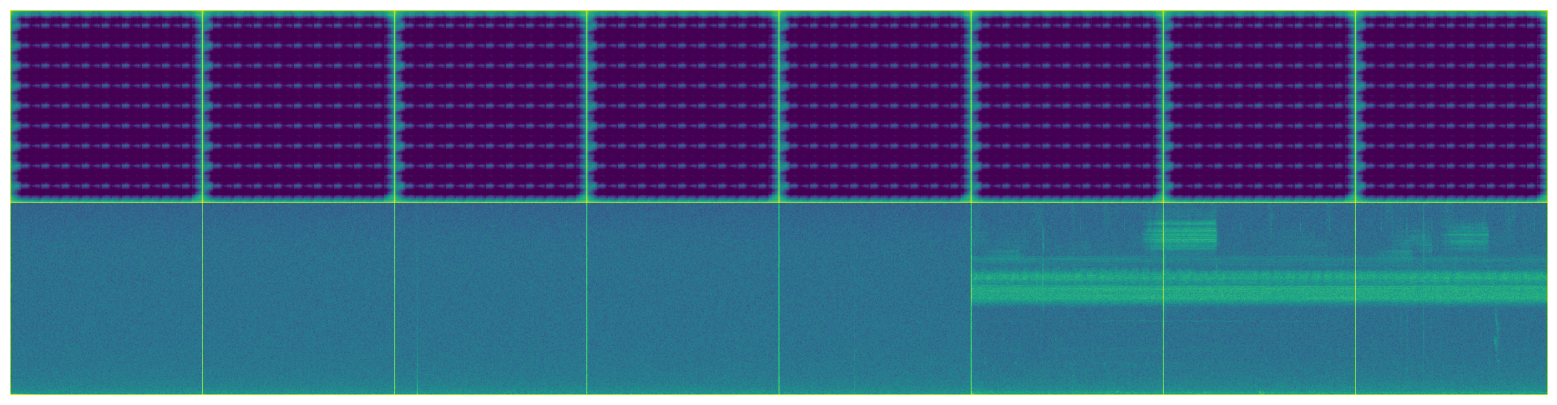

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 401 of 651 	 loss: 0.011
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 402 of 651 	 loss: 0.0122
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 403 of 651 	 loss: 0.0104
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 404 of 651 	 loss: 0.0162
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 405 of 651 	 loss: 0.0147
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 406 of 651 	 loss: 0.0303
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 407 of 651 	

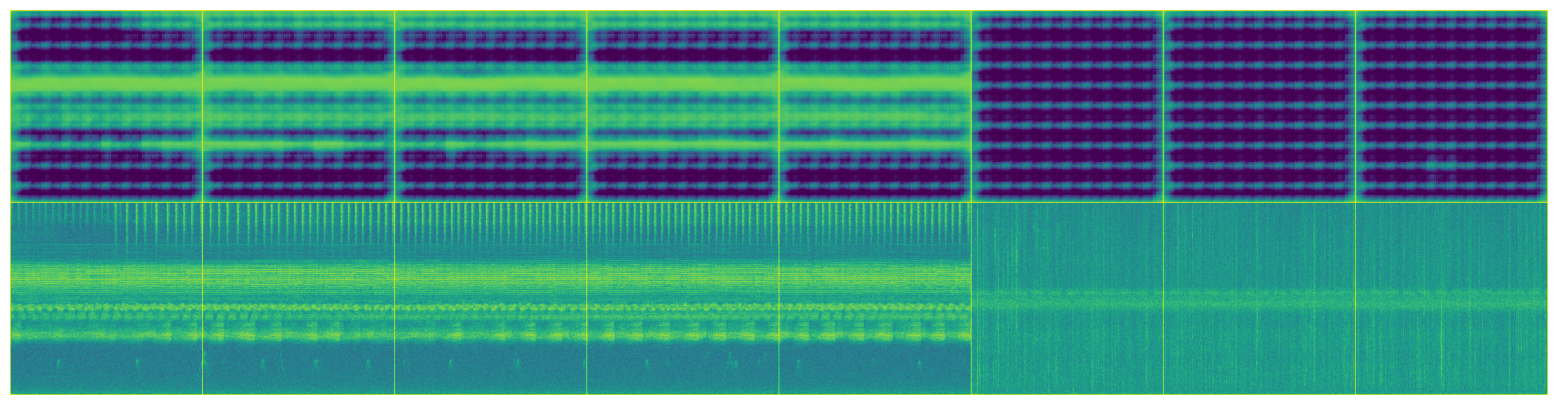

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 451 of 651 	 loss: 0.0585
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 452 of 651 	 loss: 0.1022
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 453 of 651 	 loss: 0.0257
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 454 of 651 	 loss: 0.0149
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 455 of 651 	 loss: 0.0142
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 456 of 651 	 loss: 0.011
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 457 of 651 	

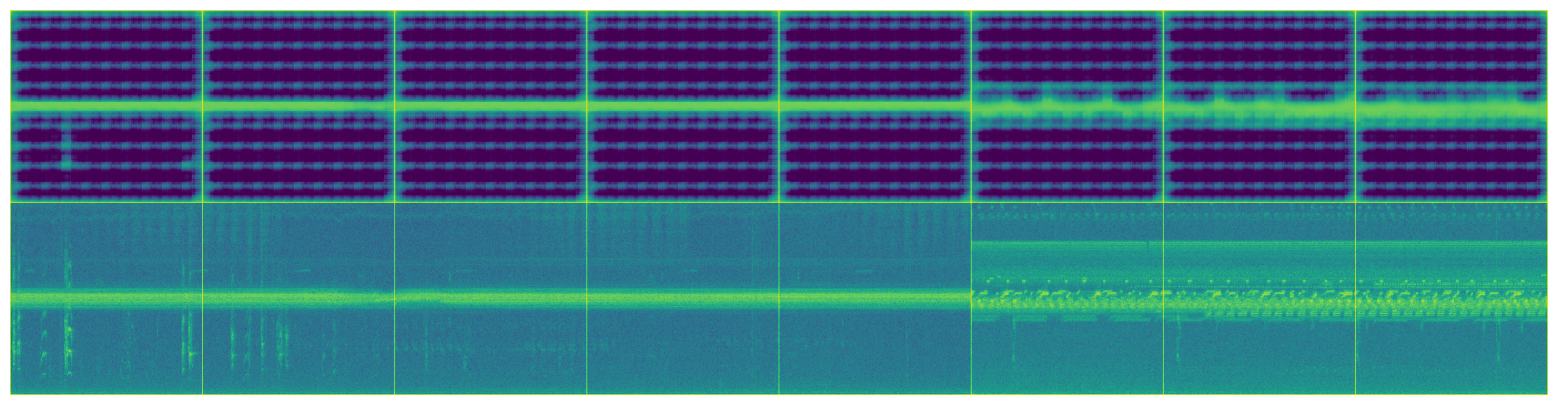

encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 501 of 651 	 loss: 0.0182
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 502 of 651 	 loss: 0.0431
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 503 of 651 	 loss: 0.0119
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 504 of 651 	 loss: 0.0157
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 505 of 651 	 loss: 0.0079
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 506 of 651 	 loss: 0.0271
encoder_shape:  torch.Size([100, 64, 9, 9])
decoder_shape:  torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 507 of 651 

In [ ]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal_zamuro/models/model_{run_name}_month_{time.month}_final.pth')
torch.save(config,f'temporal_zamuro/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
# torch.save(dataset_test, f"temporal_zamuro/datasets/dataset_test_ae_zamuro_{time.day}_70%.pth")
# torch.save(dataset_train, f"temporal_zamuro/datasets/dataset_train_ae_zamuro_{time.day}_70%.pth")

In [ ]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth', map_location=torch.device('cpu')))

In [ ]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)

In [ ]:
# encodings_size = [64,9,9]
# plt.figure(figsize=(18, 18))
# model.to("cpu")
# for i, spec in enumerate(kmeans.cluster_centers_):
#     encodings = spec.reshape(encodings_size)
#     encodings = torch.tensor(encodings).float()
#     decodings = model.decoder(encodings).detach().numpy()
#     plt.subplot(9, 9, i + 1)
#     plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
#     plt.xticks(())
#     plt.yticks(())
